In [ ]:
import matplotlib.pyplot as plt
import sys, os
sys.path.append('../')
result_dir = os.path.join(os.path.dirname(os.getcwd()), 'result', 'oup')
figure_dir = os.path.join(os.path.dirname(os.getcwd()), 'figure')
from torch import nn, Tensor
from scipy.stats import entropy

import seaborn as sns

from src.metric import c2st
from src.simulator.oup import oup
import torch 
import torch.nn.functional as F
import numpy as np
from src.plot import plot_recovery
import matplotlib
from matplotlib.patches import Patch

plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

In [2]:
mc_ref = torch.load(os.path.join(result_dir, 'oup_mc_n_10000.pt'), map_location = torch.device('cpu'))

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_82881/2506929167.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mc_ref = torch.load(os.path.join(result_dir, 

In [3]:
x = np.load(os.path.join(result_dir, 'oup_x.npy'))
theta = np.load(os.path.join(result_dir, 'oup_theta.npy'))
x = torch.from_numpy(x).float()
theta = torch.from_numpy(theta).float()

In [ ]:
def obtain_nlpd_for_multi_run(theta, x, n_tl_str: str, n_mlmc_str: str):
    patience_list = [1, 20, 100, 1000]
    n_sim = 20
    mlmc_nlpd = np.zeros((n_sim, ))
    tl_nlpd = np.zeros((n_sim, len(patience_list)))

    for i in range(n_sim):
        for j in range(len(patience_list)):
            patience = patience_list[j]
            tl_net = torch.load(os.path.join(
                result_dir, 'oup_tl_n_' + n_tl_str + '_pa_' + str(patience) + '_' + str(i) + '.pt'), map_location=torch.device('cpu'))
            tl_nlpd[i, j] = - tl_net.log_prob_unstandardized(theta, x).detach().median().numpy().item()

        mlmc_net = torch.load(os.path.join(
                result_dir, 'oup_mlmc_n_' + n_mlmc_str + '_' + str(i) + '.pt'), map_location=torch.device('cpu'))
        mlmc_nlpd[i] = - mlmc_net.log_prob_unstandardized(theta, x).detach().median().numpy().item()


    return mlmc_nlpd, tl_nlpd

In [5]:
def obtain_kl(approximated_densities, exact_densities, forward = True):
    
    jitter = 1e-20
    exact_densities = np.clip(exact_densities, jitter, None)

    kl = np.zeros((approximated_densities.shape[0]))

    for i in range(approximated_densities.shape[0]):

        if forward:
            kl[i] = entropy(exact_densities[i], approximated_densities[i]) # forward KL divergence 

        else:
            kl[i] = entropy(approximated_densities[i], exact_densities[i])

    return kl

def obtain_avg_kl(net_approx, net_ref, x, num_samples = 2000):

    with torch.no_grad():
        post_ref = net_ref.sample_unstandardized(num_samples = num_samples, condition = x)
        dens_def = torch.stack([net_ref.log_prob_unstandardized(post_ref[:, i, :], condition = x) for i in range(num_samples)])
        dens_approx = torch.stack([net_approx.log_prob_unstandardized(post_ref[:, i, :], condition = x) for i in range(num_samples)])

        kl_avg = obtain_kl(dens_approx, dens_def).mean().item()

    return kl_avg

In [6]:
def obtain_kl_for_multi_run(x, n_tl_str: str, n_mlmc_str: str, ref_net):
    patience_list = [1, 20, 100, 1000]
    n_net = 20
    mlmc_kl = np.zeros((n_net, ))
    tl_kl = np.zeros((n_net, len(patience_list)))

    for i in range(n_net):

        for j in range(len(patience_list)):
            patience = patience_list[j]
            # patience = patience_list[j]
            tl_net = torch.load(os.path.join(
                result_dir, 'oup_tl_n_' + n_tl_str + '_pa_' + str(patience) + '_' + str(i) + '.pt'), map_location=torch.device('cpu'))
            tl_kl[i, j] =  obtain_avg_kl(tl_net, ref_net, x)

        mlmc_net = torch.load(os.path.join(
                result_dir, 'oup_mlmc_n_' + n_mlmc_str + '_' + str(i) + '.pt'), map_location=torch.device('cpu'))
        mlmc_kl[i] = obtain_avg_kl(mlmc_net, ref_net, x)


    return mlmc_kl, tl_kl

In [7]:
def c2st_for_multi_run(x, n_tl_str: str, n_mlmc_str: str, ref_net):
    patience_list = [1, 20, 100, 1000]
    n_sim = x.shape[0]
    mlmc_c2st = np.zeros((n_sim, ))
    tl_c2st = np.zeros((n_sim, len(patience_list)))
    idx = 0


    ref_samples = ref_net.sample_unstandardized(num_samples = 2000, condition = x)
    
    with torch.no_grad():
        for i in range(n_sim):
                for j in range(len(patience_list)):
                        patience = patience_list[j]
                        tl_net = torch.load(os.path.join(
                                result_dir, 'oup_tl_n_' + n_tl_str + '_pa_' + str(patience) + '_' + str(idx) + '.pt'), map_location=torch.device('cpu'))
                        approx_samples = tl_net.sample_unstandardized(num_samples = 2000, condition = x)
                        tl_c2st[i, j] = c2st(ref_samples[i], approx_samples[i])
                        
                mlmc_net = torch.load(os.path.join(
                result_dir, 'oup_mlmc_n_' + n_mlmc_str + '_' + str(idx) + '.pt'), map_location=torch.device('cpu'))
                approx_samples = mlmc_net.sample_unstandardized(num_samples = 2000, condition = x)
                mlmc_c2st[i] = c2st(ref_samples[i], approx_samples[i])


    return mlmc_c2st, tl_c2st

In [13]:
#mlmc_kl, tl_kl = obtain_kl_for_multi_run(x, '1100_100', '1000_100', mc_ref)
# np.save(os.path.join(result_dir, 'oup_kl_tl_n1_100.npy'), tl_kl)
# np.save(os.path.join(result_dir, 'oup_kl_mlmc_n1_100.npy'), mlmc_kl)
# kl_mlmc_100, _ = obtain_kl_for_multi_run(x, '1100_100', '1000_100', mc_ref)
#kl_mlmc_10, _ =  obtain_kl_for_multi_run(x, '1100_100', '1000_10', mc_ref)
# nlpd_mlmc_100, _ = obtain_nlpd_for_multi_run(theta, x, '1100_100', '1000_100')
#nlpd_mlmc_10, _ = obtain_nlpd_for_multi_run(theta, x, '1100_100', '1000_10')
#kl_mlmc_100, _ = obtain_kl_for_multi_run(x, '1100_100', '1000_100', mc_ref)
#nlpd_mlmc_100, _ = obtain_nlpd_for_multi_run(theta, x, '1100_100', '1000_100')

In [ ]:
nlpd_tl_10 = np.load(os.path.join(result_dir, 'oup_tl_nlpd_10.npy'))
nlpd_mlmc_10 = np.load(os.path.join(result_dir, 'oup_mlmc_nlpd_10.npy'))
nlpd_tl_100 = np.load(os.path.join(result_dir, 'oup_tl_nlpd_100.npy'))
nlpd_mlmc_100 = np.load(os.path.join(result_dir, 'oup_mlmc_nlpd_100.npy'))

In [ ]:
kl_tl_10 = np.load(os.path.join(result_dir, 'oup_kl_tl_n1_10.npy'))
kl_mlmc_10 = np.load(os.path.join(result_dir, 'oup_kl_mlmc_n1_10.npy'))
kl_tl_100 = np.load(os.path.join(result_dir, 'oup_kl_tl_n1_100.npy'))
kl_mlmc_100 = np.load(os.path.join(result_dir, 'oup_kl_mlmc_n1_100.npy'))

In [19]:
def box_plot_oup_sensitivity(metric_list:list, ylabel:str, ax, title:str = None, 
                             add_title = True, add_xticks = True, add_ylabel = False, ylim = None, labelpad = 0):

    colors = ["#850D0C", "#A3A77D", "#A3A77D",  "#A3A77D",  "#A3A77D", "#A3A77D"]

    sns.boxplot(metric_list, ax = ax, palette = colors,#  orient='h',
                flierprops={'marker': '.', 'color': 'black', 'markersize': 5, 'markerfacecolor': 'black', 'markeredgecolor': 'black'})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if add_xticks:
        ax.set_xticklabels(["", "$1$", "$20$", "$10^2$", "$10^3$"], fontsize = 14, rotation = 0)

    else:
        ax.set_xticklabels([])


    if add_title:
        ax.set_title(title)

    if add_ylabel:
        ax.set_ylabel(ylabel, fontsize = 17, labelpad = labelpad)

    ax.tick_params(axis = 'y', labelsize = 10)


    if ylim is not None:
        ax.set_ylim(ylim)

    for patch in ax.patches:
        patch.set_alpha(0.5)
    return ax

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_82881/2816277163.py:6: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(metric_list, ax = ax, palette = colors,#  orient='h',
/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_82881/2816277163.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "$1$", "$20$", "$10^2$", "$10^3$"], fontsize = 14, rotation = 0)
/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_82881/2816277163.py:6: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(metric_list, ax = ax, palette = colors,#  orient='h',
/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_82881/2816277163.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "$1$", "$20$", "$10^2$", "$10^3$"], fontsize = 14, rotation = 0)


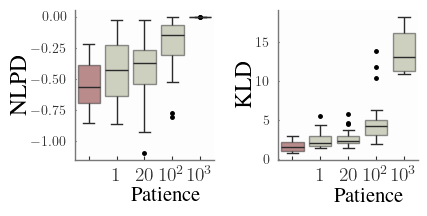

In [72]:
fig, axes = plt.subplots(1, 2, figsize = (4.5, 2.5))
axes[0] = box_plot_oup_sensitivity([nlpd_mlmc_10, nlpd_tl_10[:, 0], nlpd_tl_10[:, 1], nlpd_tl_10[:, 2], nlpd_tl_10[:, 3]], ylabel = 'NLPD', ax = axes[0], add_ylabel= True)
axes[1] = box_plot_oup_sensitivity([kl_mlmc_10, kl_tl_10[:, 0], kl_tl_10[:, 1], kl_tl_10[:, 2], kl_tl_10[:, 3]], ylabel = 'KLD', ax = axes[1], add_ylabel= True)
axes[0].text(1.5, -1.48, "Patience", fontsize = 15)
axes[1].text(1.5, -5.5, "Patience", fontsize = 15)

fig.tight_layout()
fig.savefig(os.path.join(figure_dir, 'oup_sensitivity_n1_10.pdf'), bbox_inches = 'tight')

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_82881/2816277163.py:6: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(metric_list, ax = ax, palette = colors,#  orient='h',
/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_82881/2816277163.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "$1$", "$20$", "$10^2$", "$10^3$"], fontsize = 14, rotation = 0)
/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_82881/2816277163.py:6: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(metric_list, ax = ax, palette = colors,#  orient='h',
/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_82881/2816277163.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "$1$", "$20$", "$10^2$", "$10^3$"], fontsize = 14, rotation = 0)


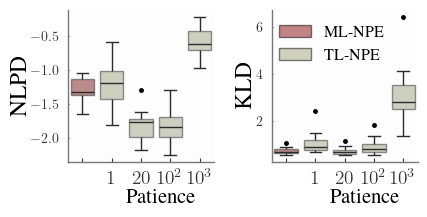

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (4.5, 2.2))
axes[0] = box_plot_oup_sensitivity([nlpd_mlmc_100, nlpd_tl_100[:, 0], nlpd_tl_100[:, 1], nlpd_tl_100[:, 2], nlpd_tl_100[:, 3]], ylabel = 'NLPD', ax = axes[0], add_ylabel= True)
axes[1] = box_plot_oup_sensitivity([kl_mlmc_100, kl_tl_100[:, 0], kl_tl_100[:, 1], kl_tl_100[:, 2], kl_tl_100[:, 3]], ylabel = 'KLD', ax = axes[1], add_ylabel= True)
fig.tight_layout()
axes[0].text(1.5, -2.94, "Patience", fontsize = 15)
axes[1].text(1.5, -1.45, "Patience", fontsize = 15)


legend_elements = [
    Patch(facecolor= "#850D0C", edgecolor='black', label='ML-NPE', alpha = 0.5),
    Patch(facecolor= "#A3A77D", edgecolor='black', label='TL-NPE', alpha = 0.5),
]

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.91, 0.9), frameon=False)
fig.savefig(os.path.join(figure_dir, 'oup_sensitivity_n1_100.pdf'), bbox_inches = 'tight')

In [259]:
fig.savefig(os.path.join(figure_dir, 'oup_sensitivity.pdf'), bbox_inches = 'tight', dpi = 300)

In [92]:
np.random.seed(42)
simulator = oup(T = 10, dt = 0.1, three_param = True)
theta = simulator.prior(n = 1)
noise = simulator.noise_generator(n = 1, m = 1)
x_low = simulator.low_simulator(theta = theta, noise = noise)
x_high = simulator.high_simulator(theta = theta, noise = noise)


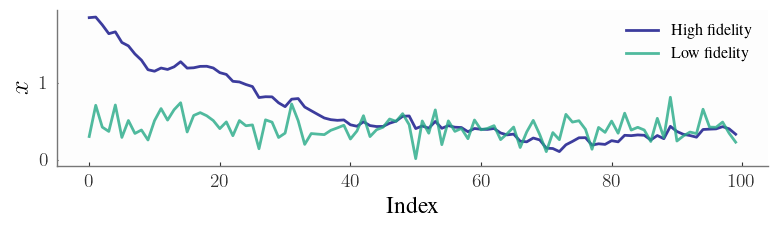

In [202]:
fig, ax = plt.subplots(1, 1, figsize = (8, 2.5))
ax.plot(x_high.squeeze(), label = "High fidelity", color = "#0C0C85", alpha = 0.8)
ax.plot(x_low.squeeze(), label = "Low fidelity", color = "#25A986", alpha = 0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Index", fontsize = 17)
ax.set_ylabel("$x$", fontsize = 19)
ax.set_ylabel
ax.legend(frameon = False)
fig.tight_layout()

In [203]:
fig.savefig(os.path.join(figure_dir, 'oup_simulator_high_low.pdf'), bbox_inches = 'tight', dpi = 300)

In [117]:
mlmc_net_10 = torch.load(os.path.join(result_dir, 'oup_mlmc_n_1000_10_1.pt'), map_location=torch.device('cpu'))
mlmc_net_100 = torch.load(os.path.join(result_dir, 'oup_mlmc_n_1000_100_1.pt'), map_location=torch.device('cpu'))
tl_net_10 = torch.load(os.path.join(result_dir, 'oup_tl_n_1010_10_pa_1_1.pt'), map_location=torch.device('cpu'))
tl_net_100 = torch.load(os.path.join(result_dir, 'oup_tl_n_1100_100_pa_20_1.pt'), map_location=torch.device('cpu'))

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_37244/193680034.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlmc_net_10 = torch.load(os.path.join(result_d

In [118]:
post_ref = mc_ref.sample_unstandardized(num_samples = 2000, condition = x).detach().numpy()
post_mlmc_10 = mlmc_net_10.sample_unstandardized(num_samples = 2000, condition = x).detach().numpy()
post_mlmc_100 = mlmc_net_100.sample_unstandardized(num_samples = 2000, condition = x).detach().numpy()
post_tl_10 = tl_net_10.sample_unstandardized(num_samples = 2000, condition = x).detach().numpy()
post_tl_100 = tl_net_100.sample_unstandardized(num_samples = 2000, condition = x).detach().numpy()

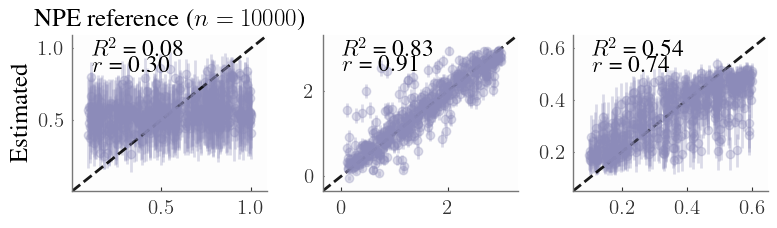

In [186]:
f = plot_recovery(post_ref, theta,  color = "#8C8BB9", param_names = [r"NPE reference ($n = 10000$)", "", "", ""], add_r2 = True, xlabel = ["", "", "", ""], 
                 fig_size = (8, 2.5), title_fontsize = 18, label_fontsize = 18, metric_fontsize = 17, tick_fontsize = 15)

In [187]:
f.savefig(os.path.join(figure_dir, 'oup_recovery_ref.pdf'), bbox_inches = 'tight', dpi = 300)

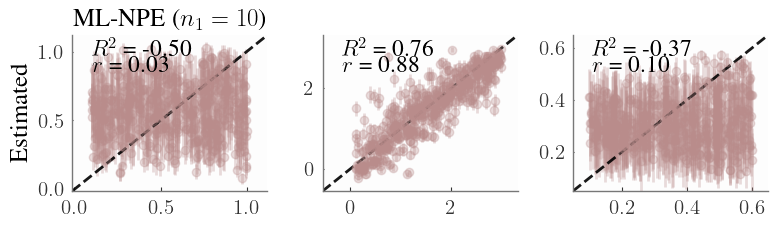

In [175]:
f = plot_recovery(post_mlmc_10, theta,  color = "#B98C8B", param_names = [r"ML-NPE ($n_1 = 10$)", "", "", ""], add_r2 = True, xlabel = ["", "", "", ""], 
                 fig_size = (8, 2.5), title_fontsize = 18, label_fontsize = 18, metric_fontsize = 17, tick_fontsize = 15)

In [176]:
f.savefig(os.path.join(figure_dir, 'oup_recovery_ml_10.pdf'), bbox_inches = 'tight', dpi = 300)

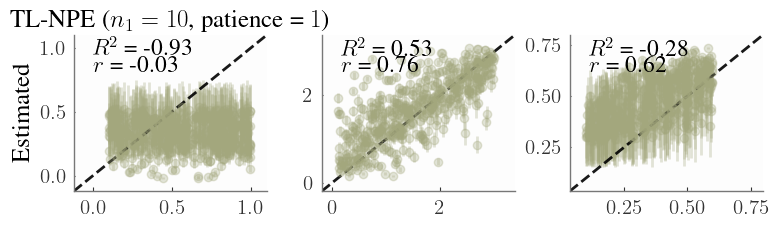

In [177]:
f = plot_recovery(post_tl_10, theta,  color = "#A3A77D", param_names = [r"TL-NPE ($n_1 = 10$, patience = $1$)", "", "", ""], add_r2 = True, xlabel = ["", "", "", ""], 
                 fig_size = (8, 2.5), title_fontsize = 18, label_fontsize = 18, metric_fontsize = 17, tick_fontsize = 15)

In [178]:
f.savefig(os.path.join(figure_dir, 'oup_recovery_tl_10.pdf'), bbox_inches = 'tight', dpi = 300)

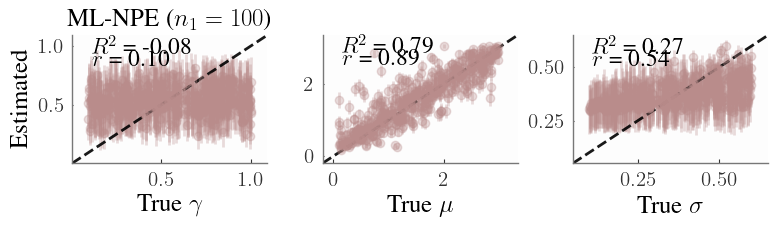

In [181]:
f = plot_recovery(post_mlmc_100, theta,  color = "#B98C8B", param_names = [r"ML-NPE ($n_1 = 100$)", "", "", ""], add_r2 = True, xlabel = [r"True $\gamma$", r"True $\mu$", r"True $\sigma$"], 
                 fig_size = (8, 2.5), title_fontsize = 18, label_fontsize = 18, metric_fontsize = 17, tick_fontsize = 15)

In [182]:
f.savefig(os.path.join(figure_dir, 'oup_recovery_ml_100.pdf'), bbox_inches = 'tight', dpi = 300)

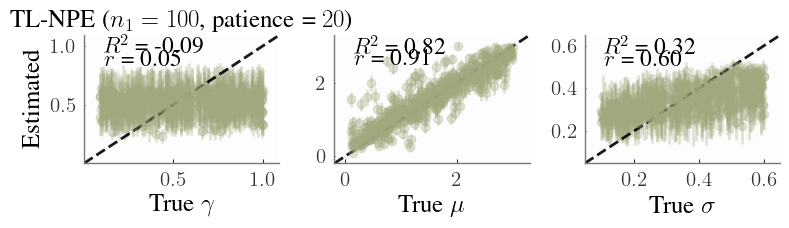

In [184]:
f = plot_recovery(post_tl_100, theta,  color = "#A3A77D", param_names = [r"TL-NPE ($n_1 = 100$, patience = $20$)", "", "", ""], add_r2 = True, xlabel = [r"True $\gamma$", r"True $\mu$", r"True $\sigma$"],
                 fig_size = (8, 2.5), title_fontsize = 18, label_fontsize = 18, metric_fontsize = 17, tick_fontsize = 15)

In [185]:
f.savefig(os.path.join(figure_dir, 'oup_recovery_tl_100.pdf'), bbox_inches = 'tight', dpi = 300)